##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Imgaug

This notebook introduces imgaug. 

*imgaug* is a library for image augmentation in machine learning experiments. It supports a wide range of augmentation techniques, allows to easily combine these and to execute them in random order or on multiple CPU cores, has a simple yet powerful stochastic interface and can not only augment images, but also keypoints/landmarks, bounding boxes, heatmaps and segmentation maps.

API: https://imgaug.readthedocs.io/en/latest/index.html

In [ ]:
# 1) We need to run this once, 
# 2) then restart the kernel 
# 3) and then skip this cell
!pip uninstall imgaug
!pip install imgaug==0.4.0

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.4.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 5.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.utils import np_utils

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

# Check that we are using the current version (as of August 2022)
assert ia.__version__ == "0.4.0"

## An example

In [ ]:
ia.seed(1) # set a seed

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
# ia.quokka() returns the image of a Quokka
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    
    # horizontal flips
    iaa.Fliplr(0.5), 

    # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Crop(percent=(0, 0.1)), 

    # Augment only p percent of all images with one or more augmenters.
    iaa.Sometimes( 
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),

    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),

    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),

    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),

    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.9, 0.9), "y": (0.9, 0.9)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-2, 2),
        shear=(-2, 2)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)

In [ ]:
images_aug.shape

(32, 64, 64, 3)

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download_file = drive.CreateFile({'id': '1D5Faq2uZg5E6m2TTFZgm4JQd0yzRgSN_'})
download_file.GetContentFile('training.zip')

download_file = drive.CreateFile({'id': '1_n2bsErcoQk2J9KKENnj7_KYYdNe_RmW'})
download_file.GetContentFile('testing.zip')

print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('training.zip', 'r')
zip_ref.extractall('local_location/')

print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('testing.zip', 'r')
zip_ref.extractall('local_location/')

Uncompressing zip file
Uncompressing zip file


In [ ]:
def load_data(directory):
    
    X = []
    Y = []
    
    # Iterate through each file in the directory
    for file in os.listdir(directory):
        # Check file name contains .jpg
        if '.jpg' in file:
            # Read the file
            image_from_disk = load_img(directory+file, target_size=(224, 224))

            # Convert to numpy array
            image = img_to_array(image_from_disk)

            # Append the image to X and the label to Y
            X.append(image)
            Y.append(file.split(sep='_')[0])
            
    return np.asarray(X), np.asarray(Y)

## Load the data

In [ ]:
X, Y = load_data('local_location/training/')

## Train/val/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape #we'll come back to this later

(2010, 224, 224, 3)

Get all images from class 0 and all images from class 1. Store them separately. 

In [ ]:
X_train_0 = X_train[y_train=="0"]
X_train_1 = X_train[y_train=="1"]

Check shapes

In [ ]:
print(X_train_0.shape)
print(X_train_1.shape)

(1018, 224, 224, 3)
(992, 224, 224, 3)


Let us see an image before augmentation from class 0

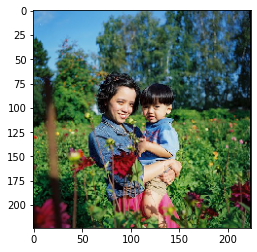

In [ ]:
plt.imshow(X_train_0[100] / 255)

Let us see an image before augmentation from class 1

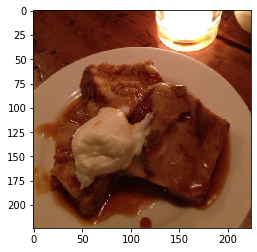

In [ ]:
plt.imshow(X_train_1[10] / 255)

Now we apply augmentation

In [ ]:
X_train_0 = seq(images=X_train_0)
X_train_1 = seq(images=X_train_1)

Shape is the same, as expected

In [ ]:
X_train_0.shape

(1018, 224, 224, 3)

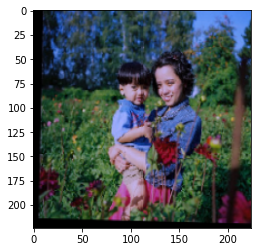

In [ ]:
plt.imshow(X_train_0[100] / 255)

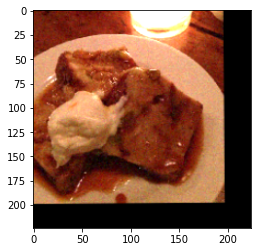

In [ ]:
plt.imshow(X_train_1[10] / 255)

Now that the images have been augmented, we can:

1) generate the y labels

2) group together the augmented and original data

In [ ]:
["0"]*2

['0', '0']

In [ ]:
y_train_0 = np.asarray(['0']*len(X_train_0))
y_train_1 = np.asarray(['1']*len(X_train_1))

In [ ]:
print(y_train_0.shape)
print(y_train_1.shape)

(1018,)
(992,)


In [ ]:
print(X_train_0.shape)
print(X_train_1.shape)

(1018, 224, 224, 3)
(992, 224, 224, 3)


In [ ]:
693+653

1346

In [ ]:
X_train_new = np.concatenate([X_train_0,X_train_1]) # this has to be done in the same order
y_train_new = np.concatenate([y_train_0,y_train_1])

In [ ]:
print(X_train_new.shape)
print(y_train_new.shape)

(2010, 224, 224, 3)
(2010,)


Now we add on the original data

In [ ]:
X_train = np.concatenate([X_train,X_train_new])
y_train = np.concatenate([y_train,y_train_new])

In [ ]:
y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)
num_classes = 10

some cleaning up

In [ ]:
del X_train_new, X_train_0, X_train_1

The final data is now ready!

In [ ]:
print(X_train.shape)
print(y_train.shape)

(4020, 224, 224, 3)
(4020, 2)


In [ ]:
1346+1346

2692

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,) # this creates (224,224,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


The model

In [ ]:
# Define the input
inputs = tf.keras.Input(shape=(224, 224, 3))

# Then we preprocess to match the data for which the model was trained on
x = preprocess_input(inputs)

# The feature extractor
x = base_model(x, training=False)

# Add global average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Some regularisation
x = tf.keras.layers.Dropout(0.2)(x)

# Output
x = tf.keras.layers.Dense(2, activation="softmax")(x)

# The full model
model = tf.keras.Model(inputs, x)

### Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=5)

Epoch 1/5
126/126 [==============================] - 42s 237ms/step - loss: 0.1059 - accuracy: 0.9634
Epoch 2/5
126/126 [==============================] - 30s 237ms/step - loss: 0.0373 - accuracy: 0.9866
Epoch 3/5
126/126 [==============================] - 30s 239ms/step - loss: 0.0298 - accuracy: 0.9898
Epoch 4/5
126/126 [==============================] - 30s 236ms/step - loss: 0.0349 - accuracy: 0.9868
Epoch 5/5
126/126 [==============================] - 30s 236ms/step - loss: 0.0202 - accuracy: 0.9920


# Tasks: 

* explore the different augmentation techniques available on imgaug

* do the epochs take longer to run with more augmentation?

* how does performance change when certain augmentation techniques are used?

* which one(s) performed best?

* which one(s) performed worst?

* reflect on the two main approaches (using Tensorflow vs imgaug)